## 1. Import Data


In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defining vector space dimension and fixed input size

In [2]:
num_classes = 5
# Number of dimensions for word embedding
embed_num_dims = 300
# Max input length (max number of words) 
max_seq_len = 64

class_names = [-2, -1, 0, 1, 2]

Importing training and testing datasets

In [3]:
import pandas as pd

df_train = pd.read_table("/content/twitter-2016train-CE.txt",sep='\t|\n',names=['id','topic','score','text'])
df_dev = pd.read_table("/content/twitter-2016dev-CE.txt",sep='\t|\n',names=['id','topic','score','text'])
df_val = pd.read_table("/content/twitter-2016devtest-CE.txt",sep='\t|\n',names=['id','topic','score','text'])
df_test = pd.read_table("/content/twitter-2016test-CE.txt",sep='\t|\n',names=['id','topic','score','text'])
# merge train and dev
df_train = pd.concat([df_train,df_dev],axis=0,ignore_index=True)
df_train = df_train.sample(frac=1, random_state=5)

df_train = df_train[~df_train['text'].isin(['Not Available'])]
df_val = df_val[~df_val['text'].isin(['Not Available'])]
df_test = df_test[~df_test['text'].isin(['Not Available'])]

df_train.head()

/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


,id,topic,score,text
7764,636404876847656960,seinfeld,1,"Stay up late, watch Seinfeld, make Steve drive..."
6812,641214034977628160,obama,-1,Y #FireBoehner? He fully funded Obama's #amnes...
7583,640929313005682688,sarah palin,-1,Saturday Night Live is going to have to find a...
5223,625865025585053697,kurt cobain,0,I hate Jon for making me watch the Kurt Cobain...
6772,638976726597406720,nokia,1,OMG. It's the 15th birthday of the Nokia 3310....


In [4]:
X_train = df_train.text
X_val = df_val.text
X_test = df_test.text

y_train = df_train.score
y_val = df_val.score
y_test = df_test.score

data = df_train.append(df_val, ignore_index=True)
data = data.append(df_test, ignore_index=True)

## Prepare input data

In [5]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [6]:
texts = [' '.join(clean_text(text)) for text in data.text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_val = [' '.join(clean_text(text)) for text in X_val]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [7]:
print(texts_train[92])

Keep in mind , Hillary 's initial refusal to apologize was n't off the cuff . It came after months of scrutiny . https : //t.co/GiraU5N5Fh


**Tokenization + fitting using keras**

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_val = tokenizer.texts_to_sequences(texts_val)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 29935


**Padding** -> each input has the same length

We defined maximun number of words for our texts and input size to our model has to be fixed - padding with zeros to keep the same input lenght (longest input in dataset is ~64 words)

In [9]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_val_pad = pad_sequences(sequence_val, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,  1611,   918,    20],
       [    0,     0,     0, ...,     2,   451,  5374],
       [    0,     0,     0, ...,   175,   111,    72],
       ...,
       [    0,     0,     0, ...,     4,     5, 17704],
       [    0,     0,     0, ...,   518,   232,  2540],
       [    0,     0,     0, ...,     4,     5, 17705]], dtype=int32)

**Categorize** labels: 

In [10]:
encoding = {
    -2 : 0,
    -1 : 1,
    0 : 2,
    1 : 3,
    2 : 4
}

# Integer labels
y_train = [encoding[x] for x in y_train]
y_val = [encoding[x] for x in y_val]
y_test = [encoding[x] for x in y_test]

In [11]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

## Import pretrained word vectors

* Importing pretrained word2vec from file and creating embedding matrix
* We will later map each word in our corpus to existing word vector

In [12]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [13]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [14]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(29936, 300)

Some of the words from our corpus were not included in the pre-trained word vectors. If we inspect those words we'll see that it's mostly spelling errors. It's also good to double check the noise in our data f.e different languages or tokenizer errors.

In [15]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 19159
New words found: 10776


## Create LSTM Pipeline

In [16]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
            embed_num_dims,
            input_length = max_seq_len,
            weights = [embedd_matrix],
            trainable=False)

In [17]:
# Parameters
output_size = 128

# Embedding Layer, biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)
model.add(Bidirectional(LSTM(units=output_size,dropout=0.3,recurrent_dropout=0.3)))
model.add(Dense(num_classes, activation='softmax'))

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy',])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 300)           8980800   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 9,421,381
Trainable params: 440,581
Non-trainable params: 8,980,800
_________________________________________________________________


## Train the Model

In [19]:
batch_size = 64
epochs = 50

hist = model.fit(X_train_pad, y_train, 
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val_pad,y_val))

Epoch 1/50
101/101 [==============================] - 79s 721ms/step - loss: 1.2399 - accuracy: 0.5086 - val_loss: 1.1661 - val_accuracy: 0.4951
Epoch 2/50
101/101 [==============================] - 71s 706ms/step - loss: 1.0672 - accuracy: 0.5503 - val_loss: 1.0917 - val_accuracy: 0.5370
Epoch 3/50
101/101 [==============================] - 70s 696ms/step - loss: 1.0146 - accuracy: 0.5766 - val_loss: 1.1189 - val_accuracy: 0.5462
Epoch 4/50
101/101 [==============================] - 72s 709ms/step - loss: 0.9917 - accuracy: 0.5853 - val_loss: 1.1132 - val_accuracy: 0.5068
Epoch 5/50
101/101 [==============================] - 77s 766ms/step - loss: 0.9749 - accuracy: 0.5805 - val_loss: 1.0838 - val_accuracy: 0.5333
Epoch 6/50
101/101 [==============================] - 69s 688ms/step - loss: 0.9441 - accuracy: 0.5962 - val_loss: 1.0759 - val_accuracy: 0.5364
Epoch 7/50
101/101 [==============================] - 71s 700ms/step - loss: 0.9269 - accuracy: 0.6117 - val_loss: 1.0807 - val_ac

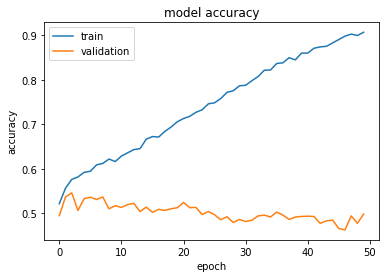

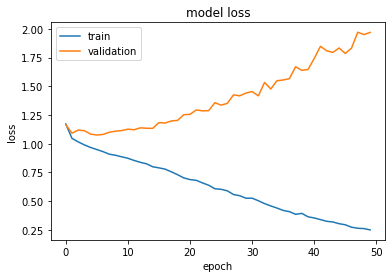

In [22]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

In [23]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [24]:
print("Accuracy: {:.2f}%".format(accuracy_score(df_test.score, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df_test.score, predictions, average='micro') * 100))

Accuracy: 47.09%

F1 Score: 47.09


#### Plotting confusion Matrix:

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes,
              normalize=False,
              title=None,
              cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 47.09


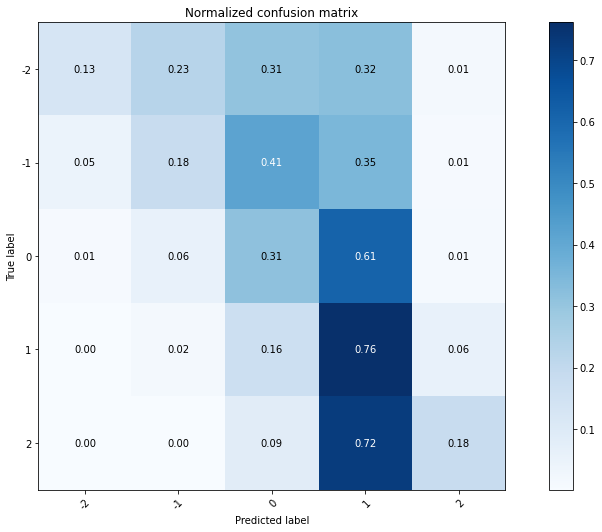

In [26]:
print("\nF1 Score: {:.2f}".format(f1_score(df_test.score, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(df_test.score, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()